In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

In [2]:
# 定义网格单元结构体
class GridCell:
    def __init__(self):
        self.id = 0 # 网格单元编号
        self.parent_id = 0 # 父单元编号
        self.child_id = [0,0] # 两个子单元编号，若无子单元则为0
        self.xmin = 0.0 # 单元格的左边界
        self.xmax = 0.0 # 单元格的右边界
        self.leaf_id = 0 # 叶子单元编号，若不是叶子单元则为0
        self.lev = 0 #单元的层数编号

In [3]:
# 定义构建网格的函数
def construct_grid(grid, leaf_id, parent_id, xmin, xmax):
    cell = GridCell() # 构建网格单元
    cell.id = len(grid) + 1 # 网格单元编号
    cell.parent_id = parent_id # 父单元编号
    cell.xmin = xmin # 单元格左边界
    cell.xmax = xmax # 单元格右边界
    cell.leaf_id = leaf_id # 叶子单元编号
    # 新单元格无子单元
    cell.child_id[0] = 0
    cell.child_id[1] = 0
    cell.lev = grid[parent_id-1].lev+1 # 单元格层数
    grid.append(cell) # 将新的元素加到list的最后面，位置为当前最后一个元素的下一个元素

In [4]:
# 定义细化网格的函数
def refinement_grid(Lid, grid, leaf_id, parent_id, xmin, xmax, rand_idx):
    if grid[rand_idx].leaf_id != 0:
        grid[rand_idx].leaf_id = 0
    construct_grid(grid, leaf_id, parent_id, xmin, (xmax+xmin) / 2.0)
    Lid.append(grid[-1].id)
    grid[rand_idx].child_id[0] = len(grid)
    leaf_id += 1
    construct_grid(grid, leaf_id, parent_id, (xmax+xmin) / 2.0, xmax)
    Lid.append(grid[-1].id)
    grid[rand_idx].child_id[1] = len(grid)

In [5]:
#定义查找最小网格函数
def find_ml(Lid, grid):
    fmin = grid[Lid[0]-1].xmax - grid[Lid[0]-1].xmin
    for i in Lid:
        if grid[i-1].xmax - grid[i-1].xmin < fmin:
            fmin = grid[i-1].xmax - grid[i-1].xmin
    return fmin

In [6]:
# 加密准则
def generate_int(grid, past_Lid, u, adaptive_index, adaptive_index_l, adaptive_index_r):
    Fj = 0
    nj = len(past_Lid)
    for j in range(nj):
        if j == nj-1:
            Fj = abs((u[0]-u[j])/max(u[j],u[0]))
            if Fj > 0.5:#加密条件
                adaptive_index.append(past_Lid[j])
                adaptive_index_l.append(past_Lid[j-1])
                adaptive_index_r.append(past_Lid[0])
            
        else :
            Fj = abs((u[j+1]-u[j])/max(u[j],u[j+1]))
            if Fj > 0.5:#加密条件
                adaptive_index.append(past_Lid[j])
                adaptive_index_l.append(past_Lid[j-1])
                adaptive_index_r.append(past_Lid[j+1]) 

In [7]:
# 定义加密网格函数
def refinement_grid_N(Lid, N, grid, leaf_id, XMax, XMin, M, ad_id, past_Lid, u, adaptive_index):
    limt = (XMax - XMin) / (M * (2 ** (N - 1)))
    min_length = find_ml(Lid, grid)  # 查找最小网格
#     print("refinement_grid_N+++limt,min_length", limt, min_length)

    adaptive_index_l = []
    adaptive_index_r = []

    if min_length > limt:
        # 选择满足加密准则的叶子单元进行加密
        generate_int(grid, past_Lid, u, adaptive_index, adaptive_index_l, adaptive_index_r)

#         for i in adaptive_index:
#             print("refinement_grid_N+++adaptive_index,lev", i, grid[i - 1].lev)

        for i in range(len(adaptive_index)):
            if grid[adaptive_index[i]-1].lev - grid[adaptive_index_l[i]-1].lev == 0 and grid[adaptive_index[i]-1].lev - grid[adaptive_index_r[i]-1].lev == 0:
                refine_and_remove(grid, Lid, ad_id, adaptive_index[i], leaf_id)
            elif grid[adaptive_index[i]-1].lev - grid[adaptive_index_l[i]-1].lev != 0 and grid[adaptive_index[i]-1].lev - grid[adaptive_index_r[i]-1].lev == 0:
                refine_and_remove(grid, Lid, ad_id, adaptive_index_l[i], leaf_id)
                refine_and_remove(grid, Lid, ad_id, adaptive_index[i], leaf_id)
            elif grid[adaptive_index[i]-1].lev - grid[adaptive_index_l[i]-1].lev == 0 and grid[adaptive_index[i]-1].lev - grid[adaptive_index_r[i]-1].lev != 0:
                refine_and_remove(grid, Lid, ad_id, adaptive_index_r[i], leaf_id)
                refine_and_remove(grid, Lid, ad_id, adaptive_index[i], leaf_id)
            else:
                refine_and_remove(grid, Lid, ad_id, adaptive_index_l[i], leaf_id)
                refine_and_remove(grid, Lid, ad_id, adaptive_index_r[i], leaf_id)
                refine_and_remove(grid, Lid, ad_id, adaptive_index[i], leaf_id)
                
    elif min_length == limt:
        generate_int(grid, past_Lid, u, adaptive_index, adaptive_index_l, adaptive_index_r)
        
#         for i in adaptive_index:
#             print("refinement_grid_N+++adaptive_index,lev", i, grid[i - 1].lev)
        for i in range(len(adaptive_index)):
            if grid[adaptive_index[i]-1].xmax - grid[adaptive_index[i]-1].xmin == limt:
                pass
            else:
                if grid[adaptive_index[i]-1].lev - grid[adaptive_index_l[i]-1].lev == 0 and grid[adaptive_index[i]-1].lev - grid[adaptive_index_r[i]-1].lev == 0:
                    refine_and_remove(grid, Lid, ad_id, adaptive_index[i], leaf_id)
                elif grid[adaptive_index[i]-1].lev - grid[adaptive_index_l[i]-1].lev != 0 and grid[adaptive_index[i]-1].lev - grid[adaptive_index_r[i]-1].lev == 0:
                    refine_and_remove(grid, Lid, ad_id, adaptive_index_l[i], leaf_id)
                    refine_and_remove(grid, Lid, ad_id, adaptive_index[i], leaf_id)
                elif grid[adaptive_index[i]-1].lev - grid[adaptive_index_l[i]-1].lev == 0 and grid[adaptive_index[i]-1].lev - grid[adaptive_index_r[i]-1].lev != 0:
                    refine_and_remove(grid, Lid, ad_id, adaptive_index_r[i], leaf_id)
                    refine_and_remove(grid, Lid, ad_id, adaptive_index[i], leaf_id)
                else:
                    refine_and_remove(grid, Lid, ad_id, adaptive_index_l[i], leaf_id)
                    refine_and_remove(grid, Lid, ad_id, adaptive_index_r[i], leaf_id)
                    refine_and_remove(grid, Lid, ad_id, adaptive_index[i], leaf_id)
    else:
        pass

def refine_and_remove(grid, Lid, ad_id, index, leaf_id):
#     print("refine_and_remove+++rand_idx,Lid",index,Lid)
    rand_idx = index
    ad_id.append(rand_idx)
    parent_id = grid[rand_idx - 1].id
    # 对选中的网格单元进行加密
    xmin = grid[rand_idx - 1].xmin
    xmax = grid[rand_idx - 1].xmax
    refinement_grid(Lid, grid, leaf_id, parent_id, xmin, xmax, rand_idx - 1)
    # 在Lid中删除已加密的网格单元
    Lid.remove(rand_idx)

In [8]:
# 更新网格单元的叶子单元编号
def update_leaf_id(Lid, grid):
    for n in range(1,len(grid)):
        if grid[n].id in Lid:
            grid[n].leaf_id = Lid.index(grid[n].id)+1

In [9]:
def bubbleSort(iList1):
    """冒泡排序"""
    if len(iList1) <=1:
        return iList1
    for i in range(1,len(iList1)):
        for j in range(0,len(iList1)-i):
            if iList1[j].xmin >= iList1[j+1].xmin:
                iList1[j], iList1[j+1] = iList1[j+1], iList1[j]
    return iList1

In [10]:
#快速排序
def quicksort_by_xmin(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[0]
    left = []
    right = []
    for i in range(1, len(arr)):
        if arr[i].xmin < pivot.xmin:
            left.append(arr[i])
        else:
            right.append(arr[i])
    return quicksort_by_xmin(left) + [pivot] + quicksort_by_xmin(right)

def sort_leaf_by_xmin(grid,sorted_Lid):
    # 创建一个空列表，用于存储所有的叶子结点
    leaf_nodes = []

    # 遍历所有单元格，将叶子结点添加到 leaf_nodes 列表中
    for cell in grid:
        if cell.leaf_id != 0:
            leaf_nodes.append(cell)
    # 对叶子结点按照 xmin 属性进行排序
    sorted_leaf_nodes = bubbleSort(leaf_nodes)
    for leaf in sorted_leaf_nodes:
        sorted_Lid.append(leaf.id)

In [11]:
def No_OneD_adaptive_mesh_algorithm(xmin, xmax, N, grid, Lid, sorted_Lid, M):
    
    leaf_id = 0
    
    #更新叶子网格编号
    update_leaf_id(Lid, grid)
    
    sort_leaf_by_xmin(grid,sorted_Lid)

In [12]:
def OneD_adaptive_mesh_algorithm(xmin, xmax, N, grid, Lid, sorted_Lid, M, ad_id, u,past_Lid,adaptive_index):
    
    leaf_id = 0

    # 对网格进行加密
    refinement_grid_N(Lid, N, grid, leaf_id, xmax, xmin, M, ad_id, past_Lid, u, adaptive_index)

    #更新叶子网格编号
    update_leaf_id(Lid, grid)
    
    # 对叶子结点按照 xmin 从大到小的属性进行排序，并将编号存储入sorted_Lid
    sort_leaf_by_xmin(grid,sorted_Lid)
#     print("OneD_adaptive_mesh_algorithm++++++sorted_Lid",sorted_Lid)

In [13]:
# 定义构建网格的函数
def construct_grid_c(grid, leaf_id, parent_id, xmin, xmax):
    cell = GridCell() # 构建网格单元
    cell.parent_id = parent_id # 父单元编号
    cell.xmin = xmin # 单元格左边界
    cell.xmax = xmax # 单元格右边界
    cell.leaf_id = leaf_id # 叶子单元编号
    # 新单元格无子单元
    cell.child_id[0] = 0
    cell.child_id[1] = 0
    grid.append(cell) # 将新的元素加到list的最后面，位置为当前最后一个元素的下一个元素

In [14]:
def divide_segment(grid, xmin, xmax, M):
    construct_grid_c(grid, 1, 0, xmin, xmax)
    temp = (xmin + xmax)/2.0
    m = M // 2
    if m < 1:
        return grid
    else:
        return divide_segment(grid, xmin, temp, m) + divide_segment(grid, temp, xmax, m)

In [15]:
#快速排序
def quicksort_by_length(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[0]
    left = []
    right = []
    for i in range(1, len(arr)):
        if arr[i].xmax-arr[i].xmin > pivot.xmax-pivot.xmin:
            left.append(arr[i])
        else:
            right.append(arr[i])
    return quicksort_by_length(left) + [pivot] + quicksort_by_length(right)

In [16]:
# 定义函数 u(x,t)
def u(x, t):
    return np.sin(x - u(x, t) * t)

# 定义隐函数 F(u) = 0
def F(u, x, t):
    return u - np.sin(x - u * t)

# 定义求解隐函数的函数
def solve_u(X, T):
    U = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = X[i, j]
            t = T[i, j]
            u0 = np.sin(x) # 初始猜测值
            U[i, j] = fsolve(F, u0, args=(x, t))
    return U

# 网格划分可视化

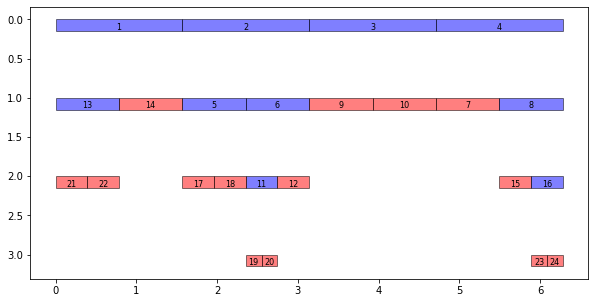

In [20]:
# 定义可视化函数
def visualize_1(grid):
    plt.figure(figsize=(10,5)) # 设置画布大小为(10,5)
    for cell in grid: # 遍历网格单元
        #x,y用于绘制矩形边界框的坐标点
        x = [cell.xmin, cell.xmax, cell.xmax, cell.xmin, cell.xmin] #矩形的四个顶点坐标以及第一个顶点的重复坐标
        y = [cell.lev,cell.lev,cell.lev+0.15,cell.lev+0.15,cell.lev]
        color = "red" if cell.id in Lid else "blue" # 如果是叶子单元格，则颜色为红色，否则为蓝色
        plt.fill(x, y, color=color, alpha=0.5, edgecolor="black") # 填充网格单元格颜色，设置透明度和边缘颜色
        plt.text((cell.xmin + cell.xmax) / 2.0,cell.lev + 0.1, str(cell.id), ha="center", va="center", fontsize=8) # 在网格单元中心添加编号文本
    plt.gca().invert_yaxis() # 反转y轴
    #plt.title("One-dimensional adaptive mesh generation") 
    plt.show() # 显示可视化结果
visualize_1(grid)

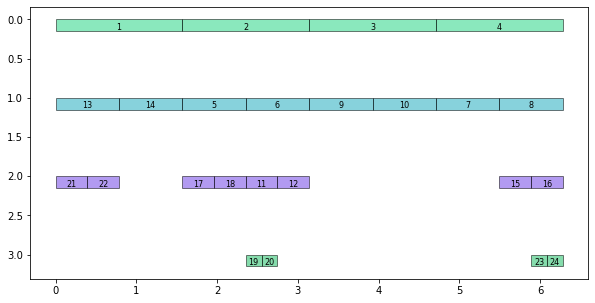

In [23]:
def visualize_2(grid):
    plt.figure(figsize=(10,5)) # 设置画布大小为(10,5)
    sizes = {} # 创建一个字典，用于保存每个cell宽度的数量
    for cell in grid: # 遍历网格单元
        width = cell.lev # 计算cell.lev
        if width not in sizes: # 如果该宽度还没有被添加到sizes字典中，则将其添加到字典中
            sizes[width] = []
        sizes[width].append(cell.id) # 将该cell加入对应宽度的列表中
    colors = {} # 创建一个字典，用于保存每种宽度的颜色
    for width, cells in sizes.items(): # 遍历每种宽度
        if width not in colors: # 如果该宽度还没有对应的颜色，则生成一种新颜色
            colors[width] = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
        color = colors[width] # 获取该宽度对应的颜色
        for cell_id in cells: # 遍历该宽度下的所有cell
            cell = grid[cell_id-1] # 获取该cell
            x = [cell.xmin, cell.xmax, cell.xmax, cell.xmin, cell.xmin] # 确定cell的顶点坐标
            y = [cell.lev,cell.lev,cell.lev+0.15,cell.lev+0.15,cell.lev]
            plt.fill(x, y, color=color, alpha=0.5, edgecolor="black") # 填充颜色
            plt.text((cell.xmin + cell.xmax) / 2.0,cell.lev + 0.1, str(cell.id), ha="center", va="center", fontsize=8) # 在网格单元中心添加编号文本
    #plt.title("One-dimensional adaptive mesh generation") # 添加标题
    plt.gca().invert_yaxis() # 反转y轴
    plt.show() # 显示可视化结果
visualize_2(grid)

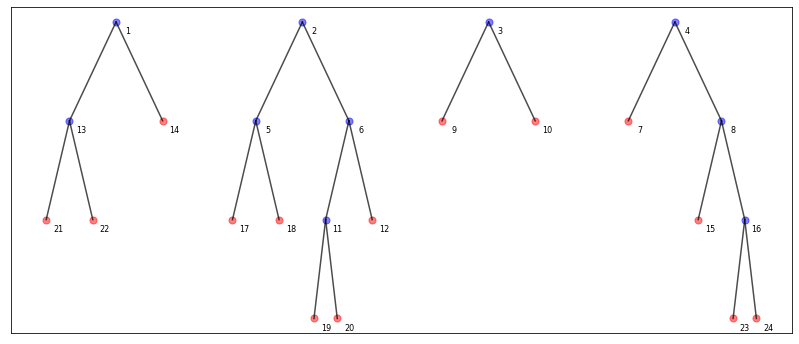

In [24]:
def visualize_5(grid):
    plt.figure(figsize=(14,6)) # 设置画布大小为
    for cell in grid: # 遍历网格单元
        color = "red" if cell.id in Lid else "blue" # 如果是叶子单元格，则颜色为红色，否则为蓝色
        plt.scatter((cell.xmin + cell.xmax) / 2.0, cell.lev, color=color, alpha=0.5, s=50) # 绘制网格单元的圆点，设置颜色和大小
        plt.text((cell.xmin + cell.xmax) / 2.0 + 0.1,cell.lev + 0.1, str(cell.id), ha="center", va="center", fontsize=8)
        if cell.parent_id != 0: # 如果网格单元有父单元
            parent_cell = grid[cell.parent_id - 1] # 获取父单元的信息
            #x,y用于绘制父子单元之间的连线的坐标点
            x = [(cell.xmin + cell.xmax) / 2.0, (parent_cell.xmin + parent_cell.xmax) / 2.0]
            y = [cell.lev, parent_cell.lev]
            plt.plot(x, y, color="black", alpha=0.7) # 绘制父子单元之间的连线
    #plt.gca().invert_yaxis() # 反转y轴
    # 隐藏坐标轴
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    #plt.title("Grid generation - treemap") # 添加标题
    plt.gca().invert_yaxis() # 反转y轴
    plt.show() # 显示可视化结果
visualize_5(grid)

# Burgers方程+T=0.8+均匀

M = 4, error = 1.274028e+00, order = -inf


C:\Users\Asus\AppData\Local\Temp\ipykernel_20460\922063868.py:156: RuntimeWarning: divide by zero encountered in log2
  order = np.log2(ec/error) # 计算阶数


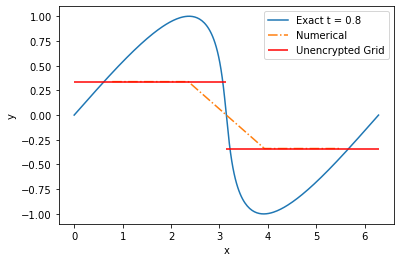

M = 8, error = 7.078522e-01, order = 8.478774e-01


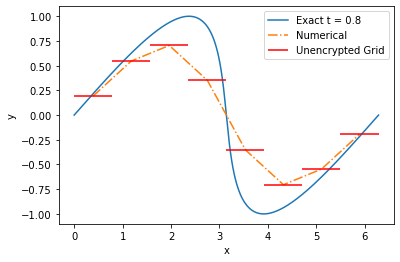

M = 16, error = 3.264239e-01, order = 1.116701e+00


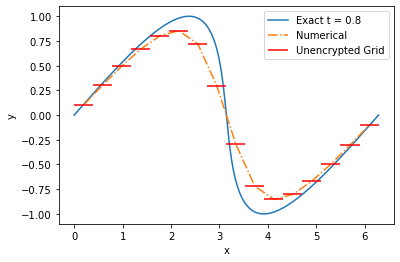

M = 32, error = 1.366686e-01, order = 1.256065e+00


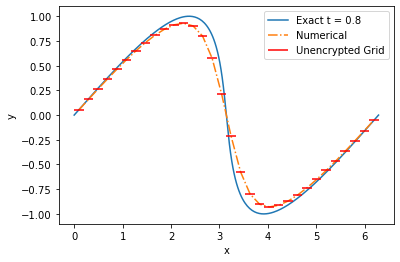

M = 64, error = 5.316872e-02, order = 1.362032e+00


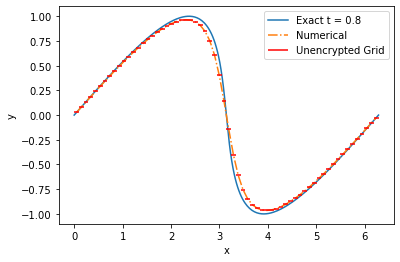

M = 128, error = 2.014862e-02, order = 1.399897e+00


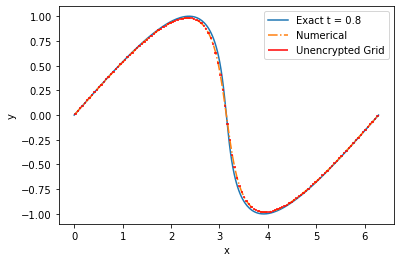

In [39]:
if __name__ == '__main__':

    # 定义精确解ut和初值ft0
    # ut = lambda x,t: np.sin(x-t) # 精确解
    ft0 = lambda x: np.sin(x) # 初值
    
    # 计算参数设置
    a = 1 # 常数a的取值
    T = 0.8 # 时间区间
    N = 1 #网格层数(包括第0层)
    M = 4 #初始网格层的网格数
    alpha = 1
    
    xmin = 0.0 
    xmax = 2*np.pi #取值范围
    
    ec = 0 # 初始化误差
    # 循环计算
    while (M <= 128):
        
        # 定义Lid动态数组存储叶子单元格的网格编号
        Lid = []
        # 定义sorted_Lid动态数组存储排序后大叶子网格单元的网格编号
        sorted_Lid= []

        # 构建初始等距网格单元(第0层网格单元)
        grid = []
        grid_c = []
        divide_segment(grid_c, xmin, xmax, M)
        grid_c = quicksort_by_length(grid_c)
        grid = grid_c[-M:].copy()
        
        quicksort_by_xmin(grid)
        
        i = 1
        for cell in grid:
            cell.id = i
            i += 1          
        for i in range(M):
            Lid.append(grid[i].id)#Lid的xmin是乱序的  

        #初始化网格
        No_OneD_adaptive_mesh_algorithm(xmin, xmax, N, grid, Lid, sorted_Lid, M)
        past_Lid = sorted_Lid
        
        hmin = find_ml(Lid, grid)#查找最小网格
        dt = 0.1*hmin # 初始化t方向网格常数
        t = np.arange(0, T, dt, dtype=float) # 时间数组
        t = np.append(t, T) # 将 T 添加到时间数组
        
        nt = len(t) # 时间节点数
        
        u = [[] for i in range(10000)] #创建多维链表存储数据
        f = [[] for i in range(10000)] 

        #初始网格
        for i in sorted_Lid:
            xmin_c = grid[i-1].xmin
            xmax_c = grid[i-1].xmax
            dx = xmax_c - xmin_c
            # 使用 quad 函数计算 ft0 在每个区间上的积分
            avg_ft0, _ = quad(ft0, xmin_c, xmax_c)  # 第二个返回值可以忽略
            u[0].append(avg_ft0 / dx)  # 将平均值赋值给 u 数组
            f[0].append(((avg_ft0 / dx)**2)/2)
            
#         print("初始u",u[0])
            
        past_ad_id = -1

        #有限体积方法随时间变化的离散化
        for n in range(1000):
            
            if n >= nt:
                break
   
            #加密
            #定义adaptive_index动态数组存储加密的网格编号
            adaptive_index = []
            sorted_Lid= []
            ad_id = []#存储被修改的Lid号
            OneD_adaptive_mesh_algorithm(xmin, xmax, N, grid, Lid, sorted_Lid, M, 
                                         ad_id, u[n], past_Lid, adaptive_index)
            
            
            #处理u，f，dt
#             print("main+++ad_id",ad_id)
#             print("main+++past_Lid",past_Lid)
#             print("main+++sorted_Lid",sorted_Lid)
            if len(ad_id) != 0 and past_ad_id != ad_id[-1]:
                xx = 0
                for i in range(len(ad_id)):
                    change_in = past_Lid.index(ad_id[i]) + xx
#                     print("main+++change_in",change_in)
                    u[n].insert(change_in, u[n][change_in]) 
                    f[n].insert(change_in, f[n][change_in])
                    xx += 1

#                 print("main++++++u",n, u[n])
#                 print(" ")
                past_ad_id = ad_id[-1]
                past_Lid = sorted_Lid
                
                hmin = find_ml(Lid, grid)#查找最小网格
#                 print("hmin 加密   ++++++++++++++++++++++:",hmin)
                dt = 0.1*hmin # 初始化t方向网格常数
                t = np.arange(0, T, dt, dtype=float) # 时间数组
                t = np.append(t, T) # 将 T 添加到时间数组
                nt = len(t) # 时间节点数


                
            nx = len(Lid)#初始网格数
            for j in range(nx):
                dx = grid[sorted_Lid[j]-1].xmax-grid[sorted_Lid[j]-1].xmin

                r = a*dt/dx

                if j < (nx-1):
                    F_0 = 0.5*(f[n][j-1]+f[n][j]-alpha*(u[n][j]-u[n][j-1]))
                    F_1 = 0.5*(f[n][j]+f[n][j+1]-alpha*(u[n][j+1]-u[n][j]))

                else:
                    F_0 = 0.5*(f[n][j-1]+f[n][j]-alpha*(u[n][j]-u[n][j-1]))
                    F_1 = 0.5*(f[n][j]+f[n][0]-alpha*(u[n][0]-u[n][j]))

                u[n+1].append(u[n][j]-r*(F_1-F_0))
                f[n+1].append(((u[n][j]-r*(F_1-F_0))**2)/2)
                        
                
                
        #求精确解
        # 定义 x 和 t 的取值范围和步长
        #print("main+++sorted_Lid",sorted_Lid)
        MM = len(u[nt-1])
        x_excat = []
        for i in sorted_Lid:
            x_excat.append(grid[i-1].xmin)
        x_excat.append(grid[sorted_Lid[-1]-1].xmax)
        t_excat = np.linspace(0, T, 5)
        # 创建网格
        X, T_excat = np.meshgrid(x_excat, t_excat)
        # 求解隐函数
        U = solve_u(X, T_excat)

        k = 0  
        error = 0.0

        for i in sorted_Lid:
            if k < MM:
                def func(x):
                    return (grid[i-1].xmax-grid[i-1].xmin)*(U[-1][k]-u[nt-1][k])**2
                fArea,err = quad(func,grid[i-1].xmin,grid[i-1].xmax)
                error += fArea
                k += 1
        error = np.sqrt(error)
        order = np.log2(ec/error) # 计算阶数
        ec = error # 当前误差作为前一次误差
        print('M = %d, error = %e, order = %e' % (M, error, order)) # 打印误差与阶数

        #可视化
        x_num = np.array([])
        x_l = np.array([])
        for i in sorted_Lid:
            x_num = np.append(x_num,(grid[i-1].xmax+grid[i-1].xmin)/2)
            x_l = np.append(x_l,grid[i-1].xmin)
            
        x_change_min = np.array([])
        x_change_max = np.array([])
        
        #存储加密单元
        ad_index = []
        for z in sorted_Lid:
            if round(grid[z-1].xmax-grid[z-1].xmin, 6) < round((xmax-xmin)/M, 6):
                ad_index.append(z)
        
        for k in ad_index:
            x_change_min = np.append(x_change_min,grid[k-1].xmin)
            x_change_max = np.append(x_change_max,grid[k-1].xmax)
        
        y_num = u[nt-1]

        # 绘制图像
        x_excat_plt = np.linspace(0, 2 * np.pi, 256)
        # 创建网格
        X_plt, T_excat = np.meshgrid(x_excat_plt, t_excat)
        # 求解隐函数
        U_plt = solve_u(X_plt, T_excat)

        plt.figure()
        plt.plot(x_excat_plt, U_plt[-1],label='Exact t = %.1f' % (T))
        plt.plot(x_num, y_num,'-.',label='Numerical')
        for i in range(len(y_num)-1):
            plt.hlines(y_num[i], x_l[i], x_l[i+1], 'r')
        plt.hlines(y_num[-1],x_l[-1],xmax, 'r',label='Unencrypted Grid')
        
        for k in range(len(ad_index)):
            for i in range(len(y_num)):
                if x_change_min[k] == x_l[i]:
                    plt.hlines(y_num[i], x_change_min[k], x_change_max[k], 'g')
        #plt.hlines(y_num[-1],x_l[-1],xmax, 'g',label='Encrypted Grid')
        plt.legend()
        #plt.title('Exact and numerical solutions ')
        plt.xlabel('x')
        plt.ylabel('y')


        plt.show()
        M *= 2

# Burgers方程+T=0.8+加密一层

M = 4, error = 1.139278e+00, order = -inf


C:\Users\Asus\AppData\Local\Temp\ipykernel_19056\2522719374.py:156: RuntimeWarning: divide by zero encountered in log2
  order = np.log2(ec/error) # 计算阶数


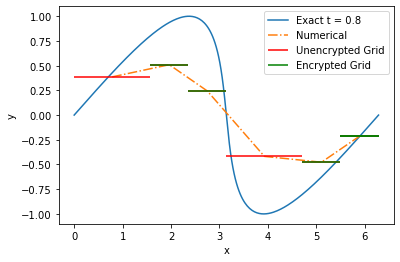

M = 8, error = 3.992738e-01, order = 1.512670e+00


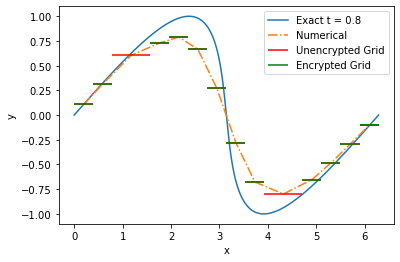

M = 16, error = 1.839432e-01, order = 1.118118e+00


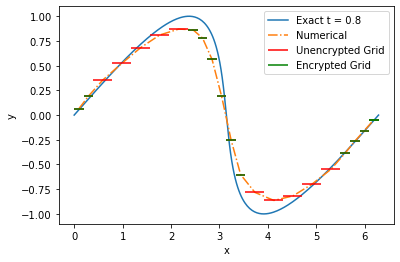

M = 32, error = 7.465867e-02, order = 1.300879e+00


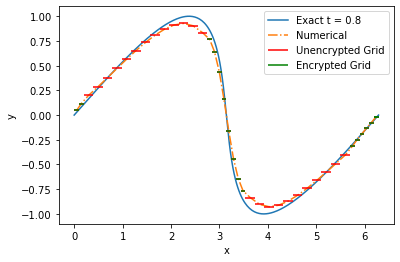

M = 64, error = 3.373335e-02, order = 1.146134e+00


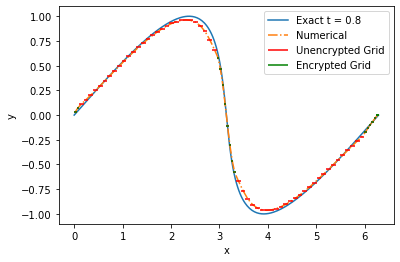

M = 128, error = 1.508746e-02, order = 1.160825e+00


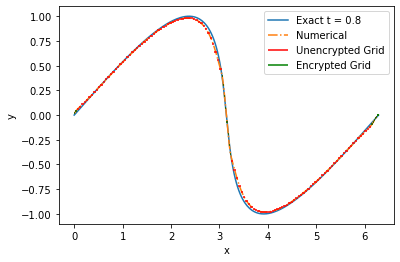

In [25]:
if __name__ == '__main__':

    # 定义精确解ut和初值ft0
    # ut = lambda x,t: np.sin(x-t) # 精确解
    ft0 = lambda x: np.sin(x) # 初值
    
    # 计算参数设置
    a = 1 # 常数a的取值
    T = 0.8 # 时间区间
    N = 2 #网格层数(包括第0层)
    M = 4 #初始网格层的网格数
    alpha = 1
    
    xmin = 0.0 
    xmax = 2*np.pi #取值范围
    
    ec = 0 # 初始化误差
    # 循环计算
    while (M <= 128):
        
        # 定义Lid动态数组存储叶子单元格的网格编号
        Lid = []
        # 定义sorted_Lid动态数组存储排序后大叶子网格单元的网格编号
        sorted_Lid= []

        # 构建初始等距网格单元(第0层网格单元)
        grid = []
        grid_c = []
        divide_segment(grid_c, xmin, xmax, M)
        grid_c = quicksort_by_length(grid_c)
        grid = grid_c[-M:].copy()
        
        quicksort_by_xmin(grid)
        
        i = 1
        for cell in grid:
            cell.id = i
            i += 1          
        for i in range(M):
            Lid.append(grid[i].id)#Lid的xmin是乱序的  

        #初始化网格
        No_OneD_adaptive_mesh_algorithm(xmin, xmax, N, grid, Lid, sorted_Lid, M)
        past_Lid = sorted_Lid
        
        hmin = find_ml(Lid, grid)#查找最小网格
        dt = 0.1*hmin # 初始化t方向网格常数
        t = np.arange(0, T, dt, dtype=float) # 时间数组
        t = np.append(t, T) # 将 T 添加到时间数组
        
        nt = len(t) # 时间节点数
        
        u = [[] for i in range(10000)] #创建多维链表存储数据
        f = [[] for i in range(10000)] 

        #初始网格
        for i in sorted_Lid:
            xmin_c = grid[i-1].xmin
            xmax_c = grid[i-1].xmax
            dx = xmax_c - xmin_c
            # 使用 quad 函数计算 ft0 在每个区间上的积分
            avg_ft0, _ = quad(ft0, xmin_c, xmax_c)  # 第二个返回值可以忽略
            u[0].append(avg_ft0 / dx)  # 将平均值赋值给 u 数组
            f[0].append(((avg_ft0 / dx)**2)/2)
            
#         print("初始u",u[0])
            
        past_ad_id = -1

        #有限体积方法随时间变化的离散化
        for n in range(1000):
            
            if n >= nt:
                break
   
            #加密
            #定义adaptive_index动态数组存储加密的网格编号
            adaptive_index = []
            sorted_Lid= []
            ad_id = []#存储被修改的Lid号
            OneD_adaptive_mesh_algorithm(xmin, xmax, N, grid, Lid, sorted_Lid, M, 
                                         ad_id, u[n], past_Lid, adaptive_index)
            
            
            #处理u，f，dt
#             print("main+++ad_id",ad_id)
#             print("main+++past_Lid",past_Lid)
#             print("main+++sorted_Lid",sorted_Lid)
            if len(ad_id) != 0 and past_ad_id != ad_id[-1]:
                xx = 0
                for i in range(len(ad_id)):
                    change_in = past_Lid.index(ad_id[i]) + xx
#                     print("main+++change_in",change_in)
                    u[n].insert(change_in, u[n][change_in]) 
                    f[n].insert(change_in, f[n][change_in])
                    xx += 1

#                 print("main++++++u",n, u[n])
#                 print(" ")
                past_ad_id = ad_id[-1]
                past_Lid = sorted_Lid
                
                hmin = find_ml(Lid, grid)#查找最小网格
#                 print("hmin 加密   ++++++++++++++++++++++:",hmin)
                dt = 0.1*hmin # 初始化t方向网格常数
                t = np.arange(0, T, dt, dtype=float) # 时间数组
                t = np.append(t, T) # 将 T 添加到时间数组
                nt = len(t) # 时间节点数


                
            nx = len(Lid)#初始网格数
            for j in range(nx):
                dx = grid[sorted_Lid[j]-1].xmax-grid[sorted_Lid[j]-1].xmin

                r = a*dt/dx

                if j < (nx-1):
                    F_0 = 0.5*(f[n][j-1]+f[n][j]-alpha*(u[n][j]-u[n][j-1]))
                    F_1 = 0.5*(f[n][j]+f[n][j+1]-alpha*(u[n][j+1]-u[n][j]))

                else:
                    F_0 = 0.5*(f[n][j-1]+f[n][j]-alpha*(u[n][j]-u[n][j-1]))
                    F_1 = 0.5*(f[n][j]+f[n][0]-alpha*(u[n][0]-u[n][j]))

                u[n+1].append(u[n][j]-r*(F_1-F_0))
                f[n+1].append(((u[n][j]-r*(F_1-F_0))**2)/2)
                        
                
                
        #求精确解
        # 定义 x 和 t 的取值范围和步长
        #print("main+++sorted_Lid",sorted_Lid)
        MM = len(u[nt-1])
        x_excat = []
        for i in sorted_Lid:
            x_excat.append(grid[i-1].xmin)
        x_excat.append(grid[sorted_Lid[-1]-1].xmax)
        t_excat = np.linspace(0, T, 5)
        # 创建网格
        X, T_excat = np.meshgrid(x_excat, t_excat)
        # 求解隐函数
        U = solve_u(X, T_excat)

        k = 0  
        error = 0.0

        for i in sorted_Lid:
            if k < MM:
                def func(x):
                    return (grid[i-1].xmax-grid[i-1].xmin)*(U[-1][k]-u[nt-1][k])**2
                fArea,err = quad(func,grid[i-1].xmin,grid[i-1].xmax)
                error += fArea
                k += 1
        error = np.sqrt(error)
        order = np.log2(ec/error) # 计算阶数
        ec = error # 当前误差作为前一次误差
        print('M = %d, error = %e, order = %e' % (M, error, order)) # 打印误差与阶数

        #可视化
        x_num = np.array([])
        x_l = np.array([])
        for i in sorted_Lid:
            x_num = np.append(x_num,(grid[i-1].xmax+grid[i-1].xmin)/2)
            x_l = np.append(x_l,grid[i-1].xmin)
            
        x_change_min = np.array([])
        x_change_max = np.array([])
        
        #存储加密单元
        ad_index = []
        for z in sorted_Lid:
            if round(grid[z-1].xmax-grid[z-1].xmin, 6) < round((xmax-xmin)/M, 6):
                ad_index.append(z)
        
        for k in ad_index:
            x_change_min = np.append(x_change_min,grid[k-1].xmin)
            x_change_max = np.append(x_change_max,grid[k-1].xmax)
        
        y_num = u[nt-1]

        # 绘制图像
        x_excat_plt = np.linspace(0, 2 * np.pi, 256)
        # 创建网格
        X_plt, T_excat = np.meshgrid(x_excat_plt, t_excat)
        # 求解隐函数
        U_plt = solve_u(X_plt, T_excat)

        plt.figure()
        plt.plot(x_excat_plt, U_plt[-1],label='Exact t = %.1f' % (T))
        plt.plot(x_num, y_num,'-.',label='Numerical')
        for i in range(len(y_num)-1):
            plt.hlines(y_num[i], x_l[i], x_l[i+1], 'r')
        plt.hlines(y_num[-1],x_l[-1],xmax, 'r',label='Unencrypted Grid')
        
        for k in range(len(ad_index)):
            for i in range(len(y_num)):
                if x_change_min[k] == x_l[i]:
                    plt.hlines(y_num[i], x_change_min[k], x_change_max[k], 'g')
        plt.hlines(y_num[-1],x_l[-1],xmax, 'g',label='Encrypted Grid')
        plt.legend()
        #plt.title('Exact and numerical solutions ')
        plt.xlabel('x')
        plt.ylabel('y')


        plt.show()
        M *= 2

# Burgers方程+T=0.8+加密二层

M = 4, error = 8.615919e-01, order = -inf


C:\Users\Asus\AppData\Local\Temp\ipykernel_20460\3322435241.py:156: RuntimeWarning: divide by zero encountered in log2
  order = np.log2(ec/error) # 计算阶数


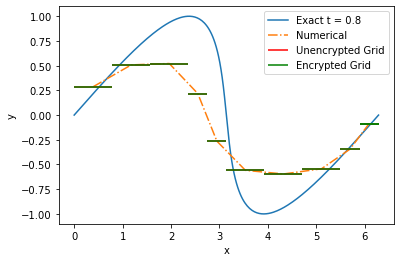

M = 8, error = 2.848624e-01, order = 1.596739e+00


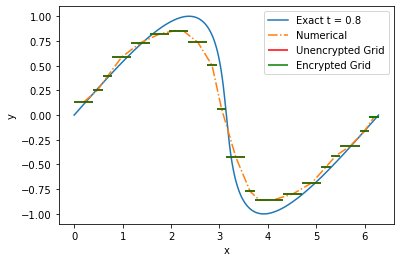

M = 16, error = 1.544813e-01, order = 8.828333e-01


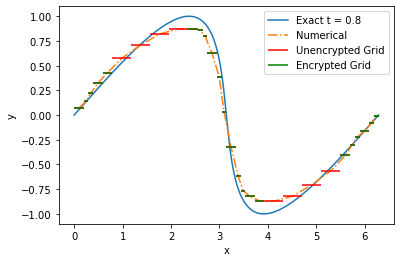

M = 32, error = 6.697588e-02, order = 1.205718e+00


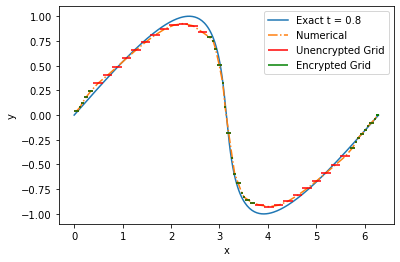

M = 64, error = 3.218800e-02, order = 1.057119e+00


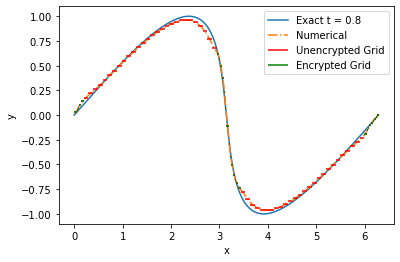

M = 128, error = 1.482017e-02, order = 1.118961e+00


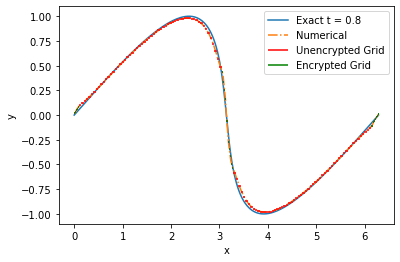

In [35]:
if __name__ == '__main__':

    # 定义精确解ut和初值ft0
    # ut = lambda x,t: np.sin(x-t) # 精确解
    ft0 = lambda x: np.sin(x) # 初值
    
    # 计算参数设置
    a = 1 # 常数a的取值
    T = 0.8 # 时间区间
    N = 3 #网格层数(包括第0层)
    M = 4 #初始网格层的网格数
    alpha = 1
    
    xmin = 0.0 
    xmax = 2*np.pi #取值范围
    
    ec = 0 # 初始化误差
    # 循环计算
    while (M <= 128):
        
        # 定义Lid动态数组存储叶子单元格的网格编号
        Lid = []
        # 定义sorted_Lid动态数组存储排序后大叶子网格单元的网格编号
        sorted_Lid= []

        # 构建初始等距网格单元(第0层网格单元)
        grid = []
        grid_c = []
        divide_segment(grid_c, xmin, xmax, M)
        grid_c = quicksort_by_length(grid_c)
        grid = grid_c[-M:].copy()
        
        quicksort_by_xmin(grid)
        
        i = 1
        for cell in grid:
            cell.id = i
            i += 1          
        for i in range(M):
            Lid.append(grid[i].id)#Lid的xmin是乱序的  

        #初始化网格
        No_OneD_adaptive_mesh_algorithm(xmin, xmax, N, grid, Lid, sorted_Lid, M)
        past_Lid = sorted_Lid
        
        hmin = find_ml(Lid, grid)#查找最小网格
        dt = 0.1*hmin # 初始化t方向网格常数
        t = np.arange(0, T, dt, dtype=float) # 时间数组
        t = np.append(t, T) # 将 T 添加到时间数组
        
        nt = len(t) # 时间节点数
        
        u = [[] for i in range(10000)] #创建多维链表存储数据
        f = [[] for i in range(10000)] 

        #初始网格
        for i in sorted_Lid:
            xmin_c = grid[i-1].xmin
            xmax_c = grid[i-1].xmax
            dx = xmax_c - xmin_c
            # 使用 quad 函数计算 ft0 在每个区间上的积分
            avg_ft0, _ = quad(ft0, xmin_c, xmax_c)  # 第二个返回值可以忽略
            u[0].append(avg_ft0 / dx)  # 将平均值赋值给 u 数组
            f[0].append(((avg_ft0 / dx)**2)/2)
            
#         print("初始u",u[0])
            
        past_ad_id = -1

        #有限体积方法随时间变化的离散化
        for n in range(1000):
            
            if n >= nt:
                break
   
            #加密
            #定义adaptive_index动态数组存储加密的网格编号
            adaptive_index = []
            sorted_Lid= []
            ad_id = []#存储被修改的Lid号
            OneD_adaptive_mesh_algorithm(xmin, xmax, N, grid, Lid, sorted_Lid, M, 
                                         ad_id, u[n], past_Lid, adaptive_index)
            
            
            #处理u，f，dt
#             print("main+++ad_id",ad_id)
#             print("main+++past_Lid",past_Lid)
#             print("main+++sorted_Lid",sorted_Lid)
            if len(ad_id) != 0 and past_ad_id != ad_id[-1]:
                xx = 0
                for i in range(len(ad_id)):
                    change_in = past_Lid.index(ad_id[i]) + xx
#                     print("main+++change_in",change_in)
                    u[n].insert(change_in, u[n][change_in]) 
                    f[n].insert(change_in, f[n][change_in])
                    xx += 1

#                 print("main++++++u",n, u[n])
#                 print(" ")
                past_ad_id = ad_id[-1]
                past_Lid = sorted_Lid
                
                hmin = find_ml(Lid, grid)#查找最小网格
#                 print("hmin 加密   ++++++++++++++++++++++:",hmin)
                dt = 0.1*hmin # 初始化t方向网格常数
                t = np.arange(0, T, dt, dtype=float) # 时间数组
                t = np.append(t, T) # 将 T 添加到时间数组
                nt = len(t) # 时间节点数


                
            nx = len(Lid)#初始网格数
            for j in range(nx):
                dx = grid[sorted_Lid[j]-1].xmax-grid[sorted_Lid[j]-1].xmin

                r = a*dt/dx

                if j < (nx-1):
                    F_0 = 0.5*(f[n][j-1]+f[n][j]-alpha*(u[n][j]-u[n][j-1]))
                    F_1 = 0.5*(f[n][j]+f[n][j+1]-alpha*(u[n][j+1]-u[n][j]))

                else:
                    F_0 = 0.5*(f[n][j-1]+f[n][j]-alpha*(u[n][j]-u[n][j-1]))
                    F_1 = 0.5*(f[n][j]+f[n][0]-alpha*(u[n][0]-u[n][j]))

                u[n+1].append(u[n][j]-r*(F_1-F_0))
                f[n+1].append(((u[n][j]-r*(F_1-F_0))**2)/2)
                        
                
                
        #求精确解
        # 定义 x 和 t 的取值范围和步长
        #print("main+++sorted_Lid",sorted_Lid)
        MM = len(u[nt-1])
        x_excat = []
        for i in sorted_Lid:
            x_excat.append(grid[i-1].xmin)
        x_excat.append(grid[sorted_Lid[-1]-1].xmax)
        t_excat = np.linspace(0, T, N)
        # 创建网格
        X, T_excat = np.meshgrid(x_excat, t_excat)
        # 求解隐函数
        U = solve_u(X, T_excat)

        k = 0  
        error = 0.0

        for i in sorted_Lid:
            if k < MM:
                def func(x):
                    return (grid[i-1].xmax-grid[i-1].xmin)*(U[-1][k]-u[nt-1][k])**2
                fArea,err = quad(func,grid[i-1].xmin,grid[i-1].xmax)
                error += fArea
                k += 1
        error = np.sqrt(error)
        order = np.log2(ec/error) # 计算阶数
        ec = error # 当前误差作为前一次误差
        print('M = %d, error = %e, order = %e' % (M, error, order)) # 打印误差与阶数

        #可视化
        x_num = np.array([])
        x_l = np.array([])
        for i in sorted_Lid:
            x_num = np.append(x_num,(grid[i-1].xmax+grid[i-1].xmin)/2)
            x_l = np.append(x_l,grid[i-1].xmin)
            
        x_change_min = np.array([])
        x_change_max = np.array([])
        
        #存储加密单元
        ad_index = []
        for z in sorted_Lid:
            if round(grid[z-1].xmax-grid[z-1].xmin, 6) < round((xmax-xmin)/M, 6):
                ad_index.append(z)
        
        for k in ad_index:
            x_change_min = np.append(x_change_min,grid[k-1].xmin)
            x_change_max = np.append(x_change_max,grid[k-1].xmax)
        
        y_num = u[nt-1]

        # 绘制图像
        x_excat_plt = np.linspace(0, 2 * np.pi, 256)
        # 创建网格
        X_plt, T_excat = np.meshgrid(x_excat_plt, t_excat)
        # 求解隐函数
        U_plt = solve_u(X_plt, T_excat)

        plt.figure()
        plt.plot(x_excat_plt, U_plt[-1],label='Exact t = %.1f' % (T))
        plt.plot(x_num, y_num,'-.',label='Numerical')
        for i in range(len(y_num)-1):
            plt.hlines(y_num[i], x_l[i], x_l[i+1], 'r')
        plt.hlines(y_num[-1],x_l[-1],xmax, 'r',label='Unencrypted Grid')
        
        for k in range(len(ad_index)):
            for i in range(len(y_num)):
                if x_change_min[k] == x_l[i]:
                    plt.hlines(y_num[i], x_change_min[k], x_change_max[k], 'g')
        plt.hlines(y_num[-1],x_l[-1],xmax, 'g',label='Encrypted Grid')
        plt.legend()
        #plt.title('Exact and numerical solutions ')
        plt.xlabel('x')
        plt.ylabel('y')


        plt.show()
        M *= 2